In [1]:
# Basic Imports
import os
import sys
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union, Type
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from functools import partial

# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

# # PyTorch for Dataloaders
# import torch.utils.data as data
# from torch.utils.data import DataLoader, Dataset
# from torchvision.datasets import MNIST
import torch

# JAX/Flax
import jax
from jax import jit
import jax.numpy as jnp
from jax import random
import flax
from flax import linen as nn
import optax
import orbax.checkpoint
from flax.training import train_state, orbax_utils
import wandb

## Create a dataset of 2 Gaussians

$p_{data} = 0.5 \mathcal{N}(\mu_1, \sigma I) + 0.5 \mathcal{N}(-\mu_1, \sigma I)$

In [2]:
key = random.PRNGKey(0)
rng, subkey1, subkey2 = random.split(key, num=3)

(2000, 10)


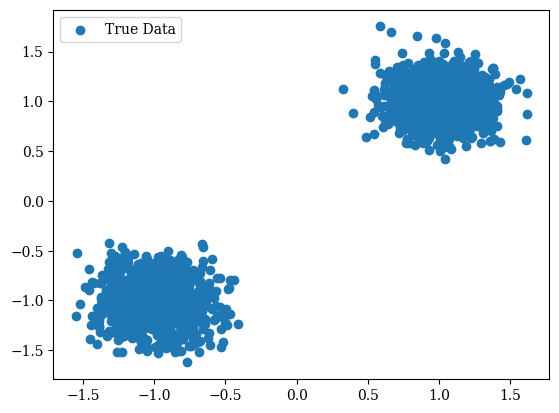

In [3]:
size = 1000 # N
std = 0.2
mean_scale = 1

# Generate data for X_0 & X_1
X_0 = mean_scale + random.normal(subkey1, shape=(size, 10)) * std
X_1 = -mean_scale + random.normal(subkey2, shape=(size, 10)) * std

# Concantenate
X = jnp.concatenate([X_0, X_1], axis=0)
print(X.shape)

# Visuaize
plt.scatter(X[:, 0], X[:, 1], label='True Data')
plt.legend()
plt.show()

## Construct data loader

In [9]:
class JaxDataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return np.array(self.X[idx])

def numpy_collate(batch):
    """
    Function to allow jnp.arrays to be used in PyTorch Dataloaders.
    """
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)
    
class NumpyLoader(torch.utils.data.DataLoader):
    """
    Custom PyTorch DataLoader for numpy/JAX arrays
    """
    def __init__(self, dataset, batch_size=1,
                 shuffle=False, sampler=None,
                 batch_sampler=None, num_workers=0,
                 pin_memory=False, drop_last=False,
                 timeout=0, worker_init_fn=None):
        super(self.__class__, self).__init__(dataset,
                                             batch_size=batch_size,
                                             shuffle=shuffle,
                                             sampler=sampler,
                                             batch_sampler=batch_sampler,
                                             num_workers=num_workers,
                                             collate_fn=numpy_collate,
                                             pin_memory=pin_memory,
                                             drop_last=drop_last,
                                             timeout=timeout,
                                             worker_init_fn=worker_init_fn)
    
train_dataset = JaxDataset(X=X)
train_loader = NumpyLoader(dataset=train_dataset, batch_size=128, shuffle=False)
train_loader_torch = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=False, collate_fn=numpy_collate)

In [13]:
batch = next(iter(train_loader))
batch_torch = next(iter(train_loader_torch))
print(np.allclose(batch, batch_torch))

True
